 <p style = "font-size: 35px;font-weight: ;text-align:center;color:#800000"> Clean Dishes vs Ecosure Violations: <b>Key Driver Analysis</b> </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 07/01/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures to get . Here, we are comparing, driver Dishwash data (no of successful/ without alarm racks runs) Clean Dishes with measure Ecosure violations (Total no of violations per Question & Mean Audit Scores).<br>

Data Used: <br>
* For <b>Dishwash Machine </b>, across 14 different brands (Applebee's, Benihana National Corp, Buffalo Wild Wings, Ihop, Modern Market, Noodles & Co., Panera, True Food Kitchen, Twin Peaks, Wingstop, Margaritaville, Cafe Zupas, O'Charleys, Texas Roadhouse)
* For <b>Ecosure Audit Data</b>, across 14 different brands (Applebee's, Benihana National Corp, Buffalo Wild Wings, Ihop, Modern Market, Noodles & Co., Panera, True Food Kitchen, Twin Peaks, Wingstop, Margaritaville, Cafe Zupas, O'Charleys, Texas Roadhouse)
* Timeline used for the analysis is May 2019 to Apr 2021 since dishwash data is only present from May 2019 to April 2021

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import os
import json
import pickle 
import pandas as pd
import numpy as np
import warnings
import itertools
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy import stats
import matplotlib
import seaborn as sns
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.4f}'.format

In [4]:
######################################################## PLOTS FUNCTIONS ###################################################

def barplots_func(X, Y, DF, X_LABEL, Y_LABEL, TITLE):
    plt.figure(figsize=(10,7))
    ax = sns.barplot(x=X, y=Y, data=DF, palette="deep")
    ax.set(xlabel = X_LABEL, ylabel = Y_LABEL)
    ax.set_title(TITLE)
    plt.xticks(rotation=90)
    plt.show()
    
def dual_ax_plots(X, Y1, Y2, DF, X_LABEL, Y1_LABEL, Y2_LABEL, TITLE):
    plt.figure(figsize=(15,7))
    color = 'darkgreen'
    ax1 = sns.lineplot(x=X, y=Y1, data=DF, color=color, marker='o')
    ax1.set_ylabel(color=color, ylabel='')
    ax1.set(xlabel = X_LABEL, ylabel = Y1_LABEL)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(TITLE)
    ax1.grid(True)
    plt.xticks(rotation=90)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'darkred'
    ax2 = sns.lineplot(x=X, y=Y2, data=DF, color=color, marker='o')
    ax2.set_ylabel(color=color, ylabel='')
    ax2.set(ylabel = Y2_LABEL)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    

######################################################## FEATURE SELECTION ###################################################

def feature_selction(x_var, y_var, df):
    df_features = df[df.month_year.notnull()]
    X = df_features[x_var]
    y = df_features[y_var]
    ols = LinearRegression()
    ols.fit(X.values, y.values)
    pls = PLSRegression(n_components=6)
    pls.fit(X.values, y.values)
    rf = RandomForestRegressor(n_estimators=20, n_jobs = -1, random_state=42)
    rf.fit(X,y)
    # print('\nBrand Name: ', brand)
    imp_mat = pd.DataFrame({'Features': X.columns, 
                            'Importance_Score_ols': ols.coef_, 
                            'Importance_Score_PLS': pls.coef_.ravel(),
                            'Importance_Score_Random_Forest': rf.feature_importances_
                           })
    display(imp_mat)
    print('\n\n')


######################################################## HYPOTHESIS TESTING ###################################################
    
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.05:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def spearman_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr = []
    lengthdata = []
    
    for brand in brands:
        corr,_= pearsonr(df_datagrouped[df_datagrouped.Brand == brand][test_var], 
                         df_datagrouped[df_datagrouped.Brand == brand][measure])
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'Correlation Coefficient': spearman_corr
                            })
    
    return test_df

######################################################## Correlation Matrix ###########################################################


def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()

In [5]:
# Reading Dishwash dataset
df_dishwash = pd.read_csv('/User/Dishwash/Month-Brand_Successful_Machine_Runs_3.csv')
df_dishwash.drop(df_dishwash.filter(regex="Unname"),axis=1, inplace=True)

df_dishwash['Successful_Racks_Percent_All'] = df_dishwash['Successful_Racks_Percent_All']*100
df_dishwash['Successful_Racks_Percent_Major'] = df_dishwash['Successful_Racks_Percent_Major']*100
df_dishwash['Successful_Racks_Percent_Minor'] = df_dishwash['Successful_Racks_Percent_Minor']*100

print('Dishwash Dataset - ')
display(df_dishwash.head())
print('\nSize: ', df_dishwash.shape)

Dishwash Dataset - 


,month_year,Brand,Successful_Racks_Major,Successful_Racks_all,Successful_Racks_Minor,RackCount,Number_of_Machines,No_of_Devices,Successful_Racks_By_Devices,Norm_RackCount,Successful_Racks_Percent_All,Successful_Racks_Percent_Major,Successful_Racks_Percent_Minor
0,May-2019,"O'Charley's, Inc.",20050,10106.0000,13310.0000,36547,9,12,842.1667,3045.5833,27.6521,54.8609,36.4189
1,May-2019,Applebee's,15128,13514.0000,14110.0000,16022,7,17,794.9412,942.4706,84.3465,94.4202,88.0664
2,May-2019,Benihana National Corp,53451,39144.0000,40675.0000,57368,19,20,1957.2000,2868.4000,68.2332,93.1722,70.9019
3,May-2019,Buffalo Wild Wings,3855,1842.0000,1915.0000,4129,3,5,368.4000,825.8000,44.6113,93.3640,46.3793
4,May-2019,IHOP,7791,7667.0000,8182.0000,8334,2,6,1277.8333,1389.0000,91.9966,93.4845,98.1761



Size:  (326, 13)


In [6]:
######################################################### Audit Data ###################################################################
########################################################################################################################################
# read aggregated audit data
df_audit = pd.read_csv('/User/csv/Audit/Ecosure_Processed-0.csv')
df_audit.drop(df_audit.filter(regex="Unname"),axis=1, inplace=True)

# Aggregating data at month year level
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
# df_audit = df_audit[(df_audit['AuditStarted'] >= '2016-09-01') & (df_audit['AuditStarted'] < '2020-03-01')]
df_audit = df_audit[df_audit.AuditStarted.notnull()]
df_audit['Date'] = df_audit['AuditStarted'].dt.date
df_audit['month_year'] = df_audit['AuditStarted'].apply(lambda x: x.strftime('%B-%Y'))

df_audit['Week_Number'] = df_audit['AuditStarted'].dt.week
df_audit['Year'] = df_audit['AuditStarted'].dt.year
df_audit['Week_No_Year'] = df_audit['Week_Number'].astype(str) + '-' + df_audit['Year'].astype(str)

df_audit['Brand'] = df_audit['ClientName']
df_audit['lat_long'] = df_audit['Latitude'].astype(str) + ',' + df_audit['Longitude'].astype(str)

# Adding KPI
df_audit['Total_No_of_Violations_per_question'] = df_audit['Total_Violations']/df_audit['count_questions']

df_audit.dropna(subset=['Latitude', 'Longitude'], how='all', inplace=True)

print('\nRaw Audit Data: ', df_audit.shape)
display(df_audit.head())

df_violations = df_audit.groupby(['month_year','ClientName'], as_index=False).agg({'Total_No_of_Violations_per_question' : 'mean',
                                                                                               'TranslatedScore' : 'mean', 
                                                                                               'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'TranslatedScore' : 'Mean_Audit_Score',
                      'ClientName' : 'Brand',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

print('\nGrouped Audit Data at month year, Brand level : ', df_violations.shape)
display(df_violations.head())


Raw Audit Data:  (129510, 51)


,ClientID,ClientName,ServiceLocationID,UnitNbr,Address1,Address2,StoreName,City,StoreType,StoreStatus,Franchisee,ConceptName,State,Country,Zipcode,Latitude,Longitude,AuditID,ReferenceNumber,AuditCycle,VisitNumber,AuditStarted,AuditEnded,EffectiveFrom,CalenderYear,CalenderMonth,CalenderMonthName,ClientType,YearName,ReportingYear,ReportingMonthName,ReportingMonth,AuditNotes,InspectionType,DWActRecInd,PreviousAuditID,AuditOrder,AuditKey,ServiceLocationKey,TranslatedScore,TranslatedRating,Total_Violations,count_questions,Date,month_year,Week_Number,Year,Week_No_Year,Brand,lat_long,Total_No_of_Violations_per_question
0,2,Applebee's,185463,83024,1650 Tappahannock Blvd.,,TAPPAHANNOCK,Tappahannock,Franchise,Open,POTOMAC FAMILY DINING GROUP OC LLC,Applebee's,VA,USA,22560,37.9067,-76.8643,3679337,AB2016FS,2.0000,1.0000,2016-09-11 14:30:00,2016-09-11 16:11:51.000,2016-10-14 10:55:16.397,2016.0000,9.0000,September,FSR,2016,2016.0000,period9,9.0000,NaN,NaN,Y,3491189.0000,3.0000,-7545654929276035072.0000,-7042526500281117696.0000,90.0000,Pass,4.0000,135.0000,2016-09-11,September-2016,36,2016,36-2016,Applebee's,"37.906682,-76.864294",0.0296
1,2,Applebee's,101247,94019,101 Lee Blvd,,SHELBYVILLE,Shelbyville,Franchise,Open,"APPLE AMERICAN GROUP, LLC",Applebee's,IN,USA,46176,39.5261,-85.7387,3679678,AB2016FS,2.0000,1.0000,2016-09-11 13:51:00,2016-09-11 15:25:41.000,2016-10-14 10:55:16.397,2016.0000,9.0000,September,FSR,2016,2016.0000,period9,9.0000,NaN,NaN,Y,3513878.0000,3.0000,2684201522030720512.0000,-6597523581081518080.0000,95.0000,Pass,2.0000,135.0000,2016-09-11,September-2016,36,2016,36-2016,Applebee's,"39.526095,-85.738668",0.0148
2,139,IHOP,1037440,360083,1425 South Federal Highway,NaN,STUART,STUART,Franchise,Open,Daniel Enea,IHOP,FL,USA,34994,27.1853,-80.2439,3679713,IH2016FL,2.0000,1.0000,2016-09-12 09:13:00,2016-09-12 11:02:37.000,2016-10-14 10:55:16.397,2016.0000,9.0000,September,FSR,2016,2016.0000,period9,9.0000,NaN,NaN,Y,3476410.0000,3.0000,-6223326056079611904.0000,-4695846108124093440.0000,80.0000,Pass,5.0000,133.0000,2016-09-12,September-2016,37,2016,37-2016,IHOP,"27.185266,-80.243879",0.0376
3,139,IHOP,1139181,5616,301 Main Street,Suite 180-182,Paterson,Paterson,Franchise,Open,Adenah Bayoh,IHOP,NJ,USA,07111,40.9149,-74.1733,3679714,IH2016FS,3.0000,1.0000,2016-09-12 09:04:00,2016-09-12 10:37:00.000,2016-10-14 10:55:16.397,2016.0000,9.0000,September,FSR,2016,2016.0000,period9,9.0000,NaN,NaN,Y,3615096.0000,4.0000,7448285683969546240.0000,-8942759154655554560.0000,100.0000,Pass,3.0000,133.0000,2016-09-12,September-2016,37,2016,37-2016,IHOP,"40.914891,-74.173345",0.0226
5,139,IHOP,443416,4494,3636 Parkway,NaN,Pigeon Forge,Pigeon Forge,Franchise,Open,Gary Wade,IHOP,TN,USA,37863,35.7831,-83.5514,3679835,IH2016FS,3.0000,1.0000,2016-09-12 08:18:00,2016-09-12 10:06:34.000,2016-10-14 10:55:16.397,2016.0000,9.0000,September,FSR,2016,2016.0000,period9,9.0000,NaN,NaN,Y,3590596.0000,4.0000,5808780972492866560.0000,-1911692229305007616.0000,85.0000,Pass,6.0000,133.0000,2016-09-12,September-2016,37,2016,37-2016,IHOP,"35.783122,-83.551424",0.0451



Grouped Audit Data at month year, Brand level :  (738, 5)


,month_year,Brand,Total_No_of_Violations_per_question,Mean_Audit_Score,No_of_Audits
0,April-2017,Applebee's,0.0496,87.4171,386
1,April-2017,Benihana National Corp,0.1125,73.0564,55
2,April-2017,Buffalo Wild Wings,0.0625,87.8807,436
3,April-2017,Cafe Zupas,0.1064,86.9193,29
4,April-2017,"Famous Dave's of America, Inc.",0.0699,NaN,25


In [7]:
# Merging Datasets
df_merged = pd.merge(df_dishwash, df_violations, how='inner', on=['month_year', 'Brand'])

print('\nMerged Dataset - ')
display(df_merged.head())
print('\nSize: ', df_merged.shape)


Merged Dataset - 


,month_year,Brand,Successful_Racks_Major,Successful_Racks_all,Successful_Racks_Minor,RackCount,Number_of_Machines,No_of_Devices,Successful_Racks_By_Devices,Norm_RackCount,Successful_Racks_Percent_All,Successful_Racks_Percent_Major,Successful_Racks_Percent_Minor,Total_No_of_Violations_per_question,Mean_Audit_Score,No_of_Audits
0,May-2019,Applebee's,15128,13514.0000,14110.0000,16022,7,17,794.9412,942.4706,84.3465,94.4202,88.0664,0.0879,79.1071,28
1,May-2019,Benihana National Corp,53451,39144.0000,40675.0000,57368,19,20,1957.2000,2868.4000,68.2332,93.1722,70.9019,0.0540,88.1333,57
2,May-2019,Buffalo Wild Wings,3855,1842.0000,1915.0000,4129,3,5,368.4000,825.8000,44.6113,93.3640,46.3793,0.0368,94.0608,145
3,May-2019,IHOP,7791,7667.0000,8182.0000,8334,2,6,1277.8333,1389.0000,91.9966,93.4845,98.1761,0.0549,8.6842,1493
4,May-2019,Modern Market,5412,2227.0000,2227.0000,5508,1,5,445.4000,1101.6000,40.4321,98.2571,40.4321,0.0864,67.8077,26



Size:  (264, 16)


In [8]:
print('\nSize: ', df_merged.month_year.unique())


Size:  ['May-2019' 'June-2019' 'July-2019' 'August-2019' 'September-2019'
 'October-2019' 'November-2019' 'December-2019' 'January-2020'
 'February-2020' 'March-2020' 'April-2020' 'May-2020' 'June-2020'
 'July-2020' 'August-2020' 'September-2020' 'October-2020' 'November-2020'
 'December-2020' 'January-2021' 'February-2021' 'March-2021' 'April-2021']


## Data Availability: In terms of Violations per audit & Successful Rack  Percentage across each month

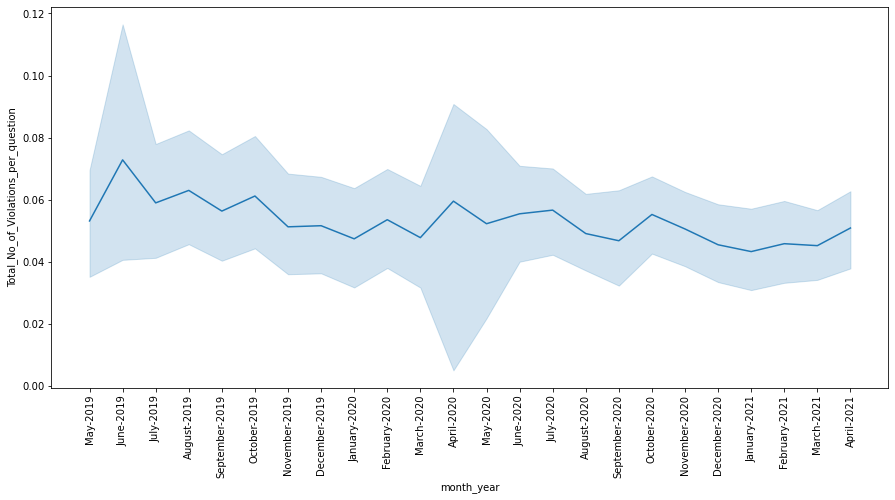

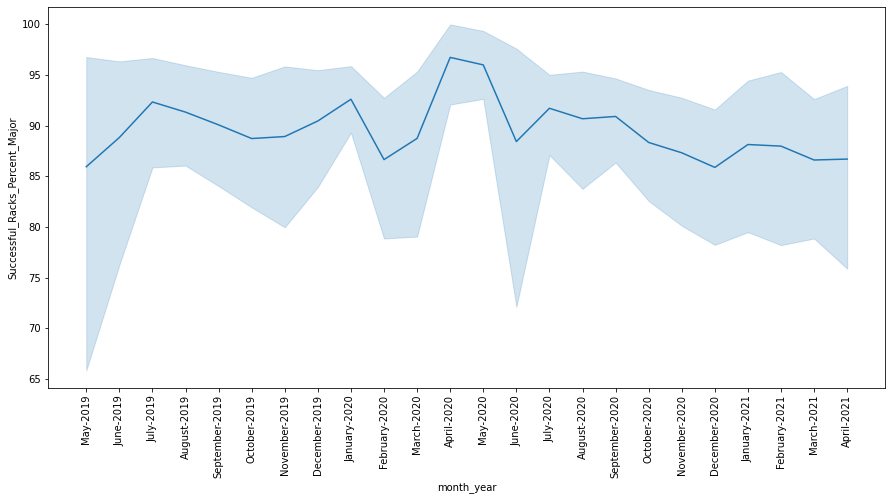

In [9]:
plt.figure(figsize=(15,7))
ax = sns.lineplot(y='Total_No_of_Violations_per_question', x='month_year', data=df_merged)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(y='Successful_Racks_Percent_Major', x='month_year', data=df_merged)
plt.xticks(rotation=90)
plt.show()

<b>Time period used for analysis is almost 1 years 11 month (23 months) from May 2019 to April 2021 since data was available for this period</b>


# Approach 1: Overall Brand Analysis

## Descriptive Analysis

Key Message-
* Brands with high number of clean dishes (successful rack count percentage) have Lower number of violations

### Clean Dishes & Violations/Question Distribution acrosss brands 1/3

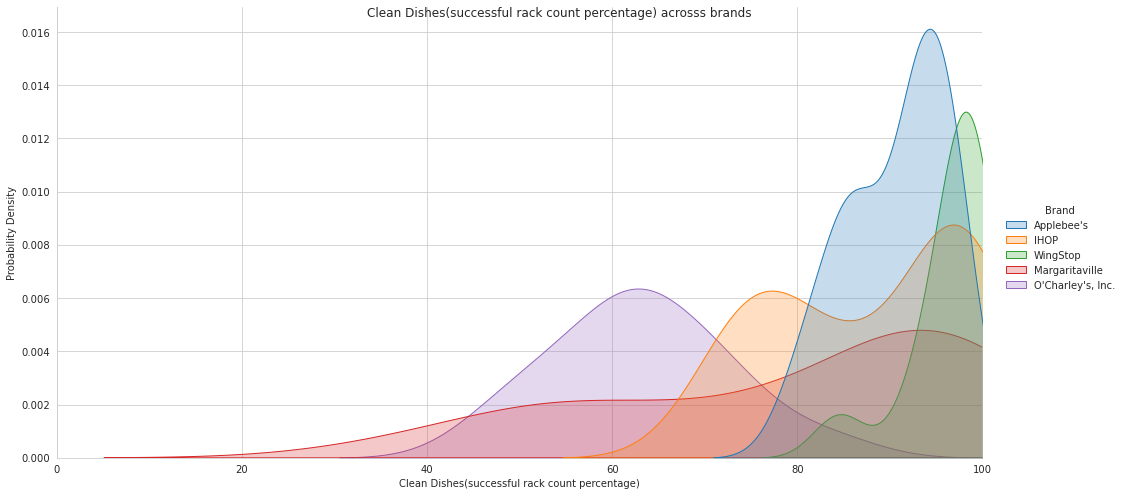

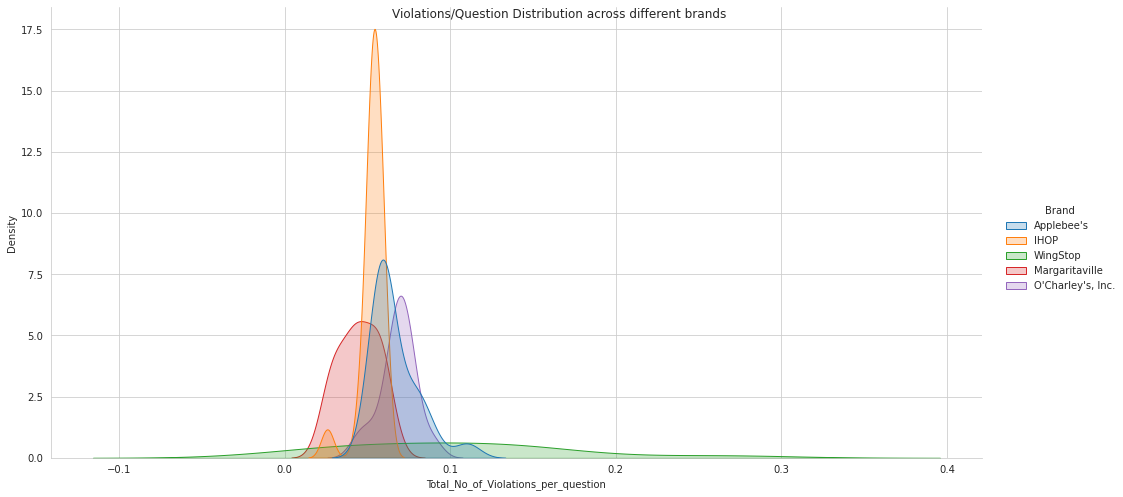

In [10]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(['IHOP', "Applebee's", "O'Charley's, Inc.", 'Margaritaville', 'WingStop'])],
                 x='Successful_Racks_Percent_Major', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,100))
ax.set(xlabel = 'Clean Dishes(successful rack count percentage)', ylabel = 'Probability Density')
ax.fig.suptitle("Clean Dishes(successful rack count percentage) acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(['IHOP', "Applebee's", "O'Charley's, Inc.", 'Margaritaville', 'WingStop'])],
                 x='Total_No_of_Violations_per_question', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
# ax.set(xlim=(0,15))
ax.fig.suptitle("Violations/Question Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

### Clean Dishes & Violations/Question Distribution acrosss brands 2/3

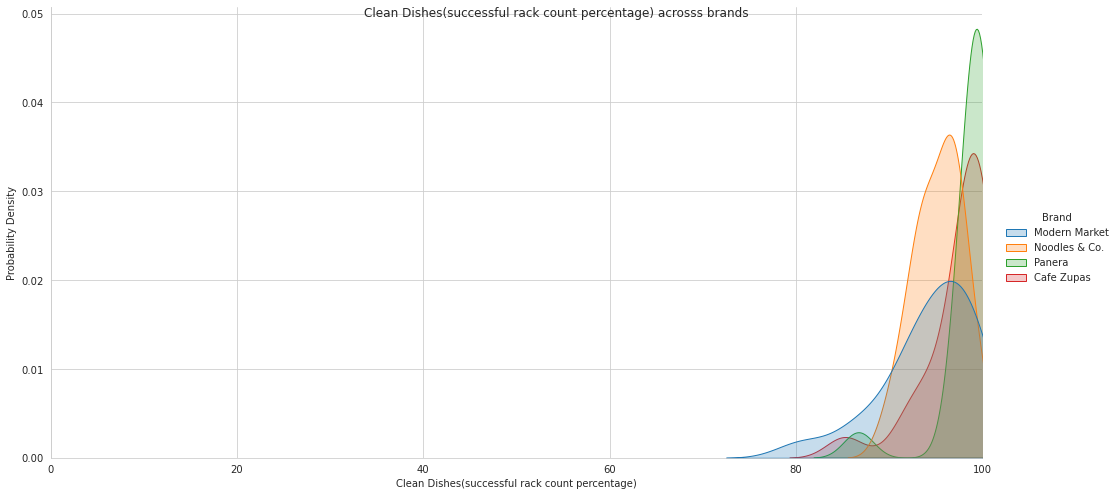

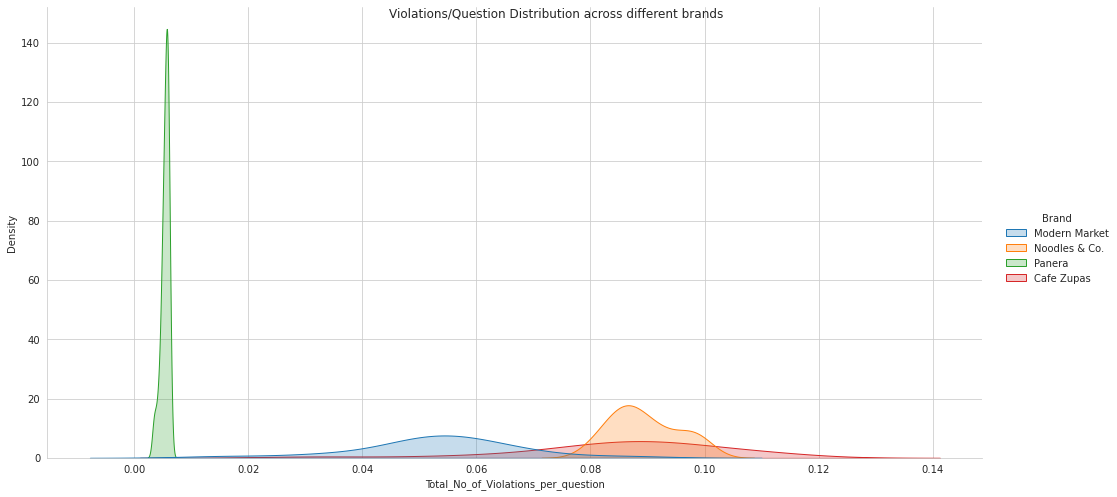

In [11]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Panera", 'Cafe Zupas', 'Noodles & Co.', 'Modern Market'])],
                 x='Successful_Racks_Percent_Major', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,100))
ax.set(xlabel = 'Clean Dishes(successful rack count percentage)', ylabel = 'Probability Density')
ax.fig.suptitle("Clean Dishes(successful rack count percentage) acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Panera", 'Cafe Zupas', 'Noodles & Co.', 'Modern Market'])],
                 x='Total_No_of_Violations_per_question', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
# ax.set(xlim=(0,15))
ax.fig.suptitle("Violations/Question Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

### Clean Dishes & Violations/Question Distribution acrosss brands 3/3

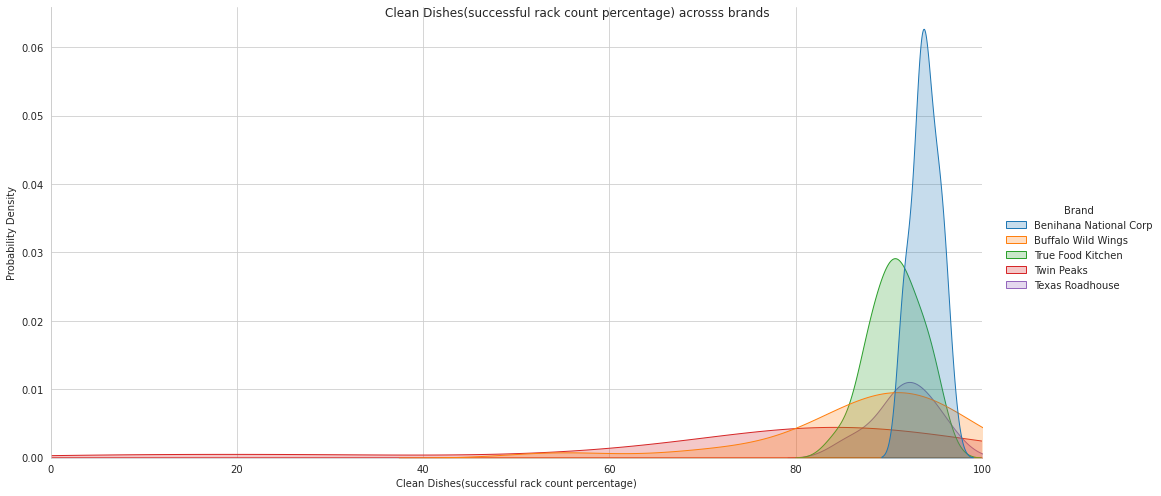

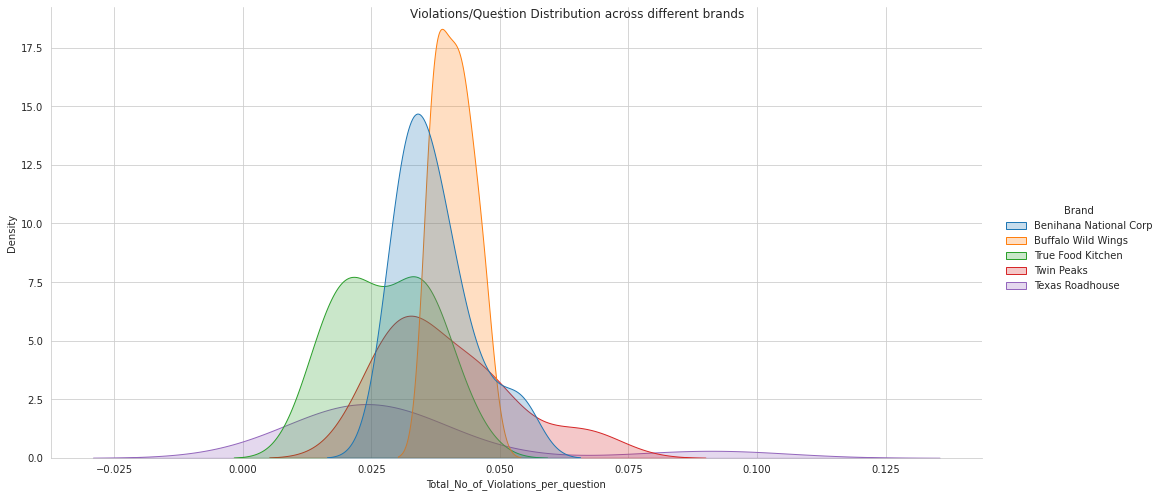

In [12]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Twin Peaks", 'True Food Kitchen', 'Texas Roadhouse', 'Benihana National Corp', 'Buffalo Wild Wings'])],
                 x='Successful_Racks_Percent_Major', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,100))
ax.set(xlabel = 'Clean Dishes(successful rack count percentage)', ylabel = 'Probability Density')
ax.fig.suptitle("Clean Dishes(successful rack count percentage) acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Twin Peaks", 'True Food Kitchen', 'Texas Roadhouse', 'Benihana National Corp', 'Buffalo Wild Wings'])],
                 x='Total_No_of_Violations_per_question', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
# ax.set(xlim=(0,15))
ax.fig.suptitle("Violations/Question Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

## Clean Dishes(succesful rack count percentage across different violation buckets)

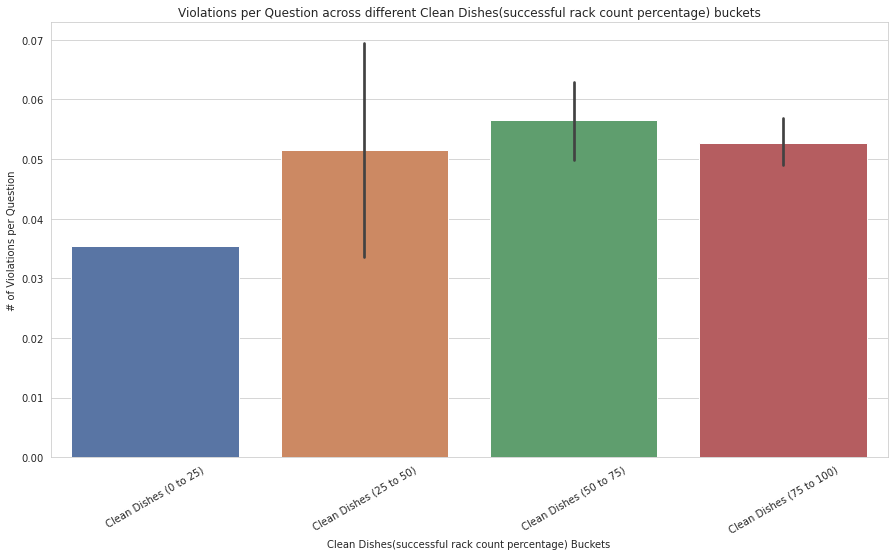

In [13]:
def req_intervals(x):
    bucket = ''
    if (x >= 0) & (x < 25):
        bucket = 'Clean Dishes (0 to 25)'
    elif (x >= 25) & (x < 50):
        bucket = 'Clean Dishes (25 to 50)'
    elif (x >= 50) & (x < 75):
        bucket = 'Clean Dishes (50 to 75)'
    else:
        bucket = 'Clean Dishes (75 to 100)'
        
    return bucket

new_order = ['Clean Dishes (0 to 25)', 'Clean Dishes (25 to 50)', 'Clean Dishes (50 to 75)', 'Clean Dishes (75 to 100)']
df_dist_senti = df_merged.copy()
df_dist_senti['Successful_Racks_percent_bucket'] = df_dist_senti['Successful_Racks_Percent_Major'].apply(req_intervals)

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Successful_Racks_percent_bucket', y='Total_No_of_Violations_per_question', data=df_dist_senti, palette = 'deep', order=new_order)
ax.set(xlabel = 'Clean Dishes(successful rack count percentage) Buckets', ylabel = '# of Violations per Question')
ax.set_title('Violations per Question across different Clean Dishes(successful rack count percentage) buckets')
plt.xticks(rotation=30)
plt.show()

# Approach 2: Brand Level Analysis

## Correlation Analysis 

Key Message - <br>
* <b>Majority of brands</b> display <b>relationship</b> between our <b>Drivers (i.e. Clean Dishes, Successful Rack count percentage)</b> and <b>Measures (i.e. Violations Per Question, Audit Score)</b> for the <b>pillar Delighted Guests</b>

### Clean Dishes vs Total No of Violations per Question

<b>8 out of 14 brands</b> shows <b>negative correlation</b> between Clean Dishes (successful rack count percentage) and total number of violations <br>
<b> i.e. With increase in Clean Dishes (successful rack count percentage), Total number of violations decreases

In [14]:
spearman_corr_brand(df_merged, 'Successful_Racks_Percent_Major', 'Total_No_of_Violations_per_question')

,Brand,Data Points,Correlation Coefficient
0,Applebee's,21,0.0605
1,Benihana National Corp,23,-0.2430
2,Buffalo Wild Wings,19,-0.0071
3,IHOP,22,0.0654
4,Modern Market,21,-0.1475
5,Noodles & Co.,24,-0.2087
6,Panera,20,-0.2060
7,True Food Kitchen,21,-0.0912
8,Twin Peaks,17,0.2247
9,WingStop,11,-0.0035


### Clean Dishes vs Total No of Violations per Question

<b>6 out of 14 brands</b> shows <b>negative correlation</b> between Clean Dishes (Successful_Racks_By_Devices) and total number of violations <br>

In [15]:
spearman_corr_brand(df_merged, 'Successful_Racks_By_Devices', 'Total_No_of_Violations_per_question')

,Brand,Data Points,Correlation Coefficient
0,Applebee's,21,0.0013
1,Benihana National Corp,23,-0.0145
2,Buffalo Wild Wings,19,0.1835
3,IHOP,22,0.3215
4,Modern Market,21,-0.0585
5,Noodles & Co.,24,-0.0199
6,Panera,20,0.1566
7,True Food Kitchen,21,-0.0872
8,Twin Peaks,17,0.3311
9,WingStop,11,0.2935


# Approach 3: Across Brands 

Key Messages-
* From Correlation Matrix with Initial Dataset, there is <b>negative correlation between Clean Dishes(Successful_Racks_By_Devices) & Violations per Question</b>
* With more <b>Refined Dataset</b>, the <b>correlation</b> becomes <b>more stronger between our Drivers (Clean Dishes(Successful_Racks_By_Devices)) and Measures of Delighted Guests(Violations per Question) for Tier 1 outcomes </b>

##  Correlation Matrix

### Data Aggregated at Month-Year & Brand Level

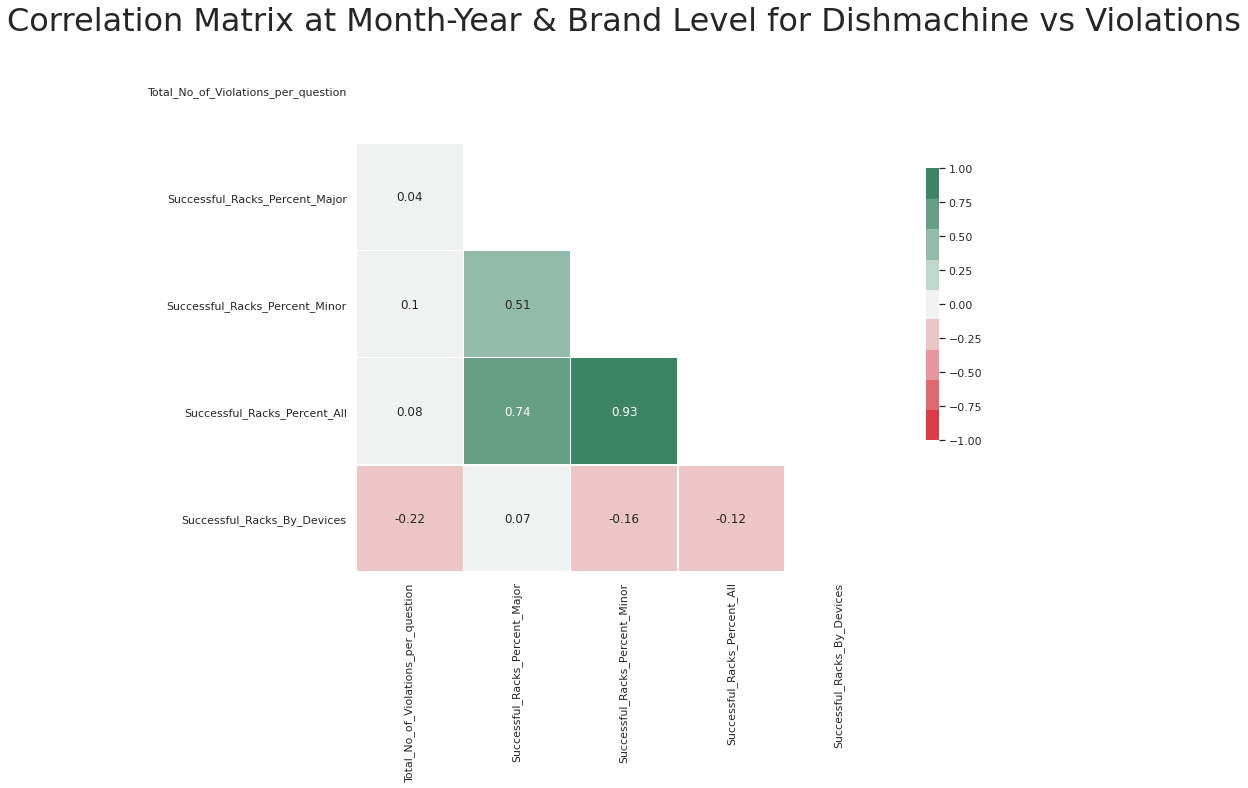

In [16]:
var = ['Total_No_of_Violations_per_question', 'Successful_Racks_Percent_Major', 'Successful_Racks_Percent_Minor', 'Successful_Racks_Percent_All', 'Successful_Racks_By_Devices']

correlation_matrix(var, df_merged, "Correlation Matrix at Month-Year & Brand Level for Dishmachine vs Violations")

In [17]:
df_merged['RackCount'].median()

14007.0

### Data Aggregated at Month-Year & Brand Level (Refined Data)

Criteria for refining dataset:

* Calculated median for RackCount <br>
* Filtered for data points having RackCount greater than median values i.e RackCount > 14007.0

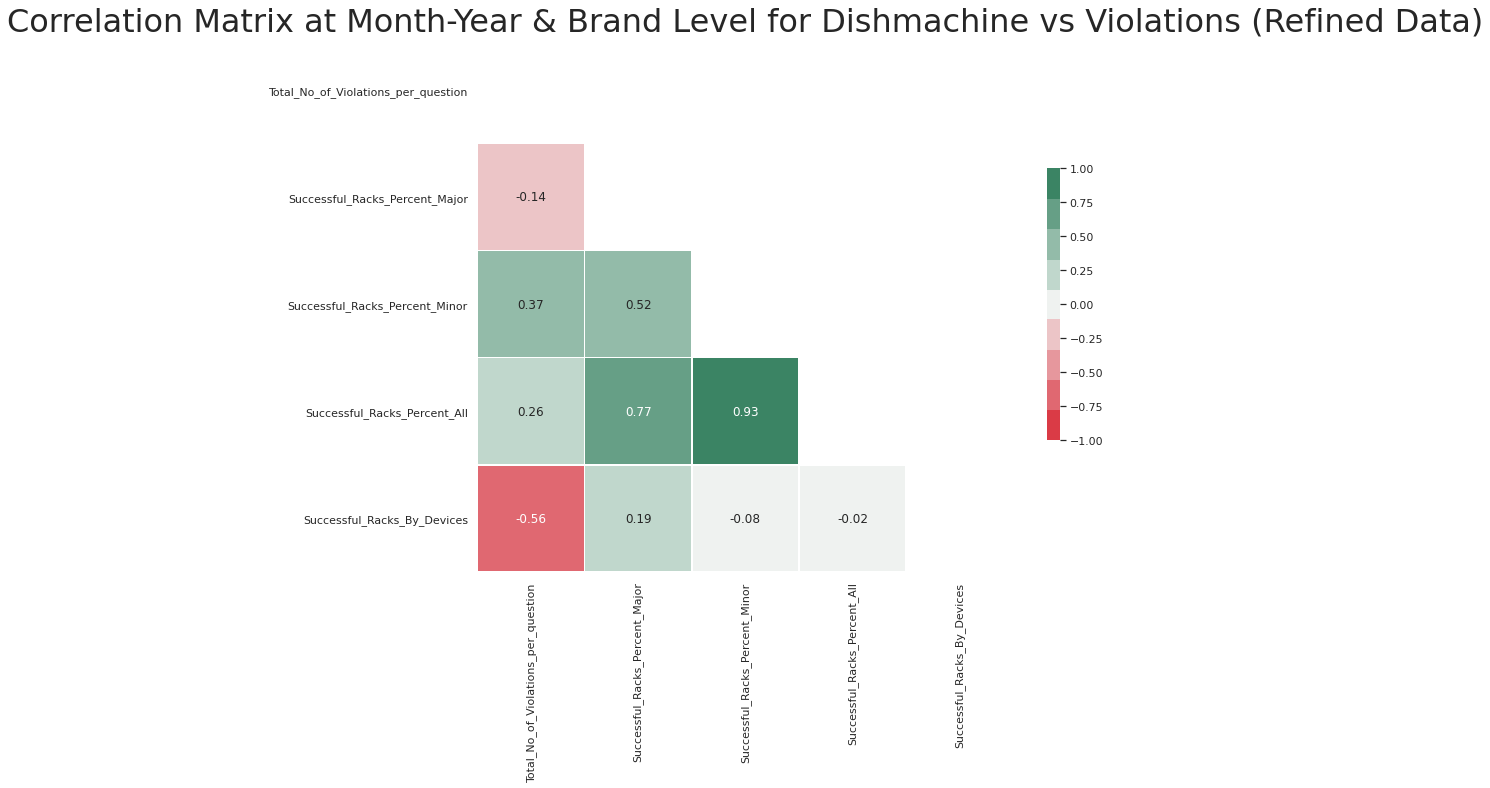

In [18]:
correlation_matrix(var, df_merged[(df_merged['RackCount'] > df_merged['RackCount'].median())],
                   "Correlation Matrix at Month-Year & Brand Level for Dishmachine vs Violations (Refined Data)")

## Hypothesis Testing (Refined Data)

Results-
* <b>Increase in Clean Dishes (Successful Rack Count Percentage) does not affect Violations per Question</b>
* <b>Increase in Clean Dishes (Successful_Racks_By_Devices), results in decreased Violations per Question</b>

### Hypothesis 1: Clean Dishes vs Total No of Violations per Question
<br>
<b>Null Hypothesis:</b> Increase in Clean Dishes (Successful Rack Count Percentage) does not affect Violations per Question
 
<b>Alternate Hypothesis:</b> Increase in Clean Dishes (Successful Rack Count Percentage), results in decreased Violations per Question

In [19]:
spearman_corr(df_merged[(df_merged['RackCount'] > df_merged['RackCount'].median())],
              'Successful_Racks_Percent_Major', 'Total_No_of_Violations_per_question')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.0279,0.7508,Accepted,Rejected


### Hypothesis 2: Clean Dishes vs Total No of Violations per Question
<br>
<b>Null Hypothesis:</b> Increase in Clean Dishes (Successful_Racks_By_Devices) does not affect Violations per Question
 
<b>Alternate Hypothesis:</b> Increase in Clean Dishes (Successful_Racks_By_Devices), results in decreased Violations per Question

In [20]:
spearman_corr(df_merged[(df_merged['RackCount'] > df_merged['RackCount'].median())],
              'Successful_Racks_By_Devices', 'Total_No_of_Violations_per_question')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.5520,0.0000,Rejected,Accepted
